In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [2]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# the columns in the dataset are:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
# we are going to use only 2 featurs i.e airliene_sentiment and text
data = df[['text','airline_sentiment']].copy(deep=True)

In [7]:
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


<Axes: >

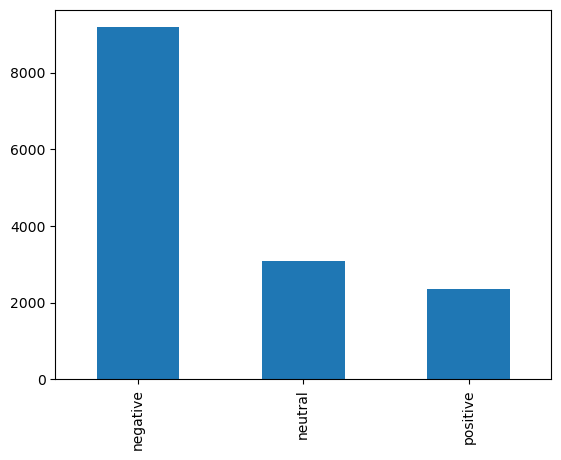

In [12]:
# Performing EDA on the selected columns
# getting unique sentiment from 'airline sentiment' feature
print(data['airline_sentiment'].value_counts())

# visualizing the rating count and imbalance
data['airline_sentiment'].value_counts().plot(kind='bar')

In [13]:
# Clearly neutral and positive sentiments are almost in balance, but negative's are almost 3 times as others
# We need to balance to the dataset using oversampling or undersampling
# Else we can also incorporate data balance during model training phase by using class weights.
# But we wil stick to conventional approach of oversampling neutral and positive sentiments

In [14]:
from sklearn.utils import resample

In [18]:
neg = data[data['airline_sentiment'] == 'negative'].copy(deep=True)
pos = data[data['airline_sentiment'] == 'positive'].copy(deep=True)
neu = data[data['airline_sentiment'] == 'neutral'].copy(deep=True)

In [19]:
neu_resampled = resample(neu, replace=True, n_samples=len(neg), random_state=123)
pos_resampled = resample(pos, replace=True, n_samples=len(neg), random_state=123)

In [21]:
# Cheking the shape of resampled data
neu_resampled.shape, pos_resampled.shape, neg.shape

((9178, 2), (9178, 2), (9178, 2))

In [22]:
# Combining upsampled data
data_balanced = pd.concat([neg, neu_resampled, pos_resampled])

negative    9178
neutral     9178
positive    9178
Name: airline_sentiment, dtype: int64


<Axes: >

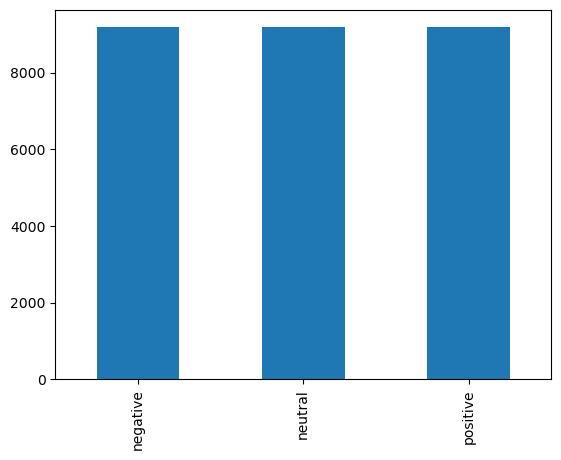

In [24]:
# Performing EDA on the selected columns
# getting unique sentiment from 'airline sentiment' feature
print(data_balanced['airline_sentiment'].value_counts())

# visualizing the rating count and imbalance after resampling
data_balanced['airline_sentiment'].value_counts().plot(kind='bar')

In [34]:
# resetting the index after upsampling
data_balanced.reset_index(drop=True, inplace=True)

In [26]:
# removing the twitter handle part of the reviews - '@___'

import re

def remove_pattern(text, pattern):
    # we will find the pattern and store for next step
    r = re.findall(pattern, text)
    
    # remove the @___ from the sentences in the data
    for i in r:
        text = re.sub(i,"", text)
        
        return text

In [38]:
# Using lambda funtion to apply remove_pattern function to entire dataset

data_balanced['tidy_text'] = data_balanced['text'].apply(lambda x: remove_pattern(x,"@[\w]*"))

In [40]:
data_balanced.head()

,text,airline_sentiment,tidy_text
0,@VirginAmerica it's really aggressive to blast...,negative,"it's really aggressive to blast obnoxious ""en..."
1,@VirginAmerica and it's a really big bad thing...,negative,and it's a really big bad thing about it
2,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay $30 a flight for seats th...
3,@VirginAmerica SFO-PDX schedule is still MIA.,negative,SFO-PDX schedule is still MIA.
4,@VirginAmerica I flew from NYC to SFO last we...,negative,I flew from NYC to SFO last week and couldn'...


In [41]:
# Removing punctuations, numbers and special characters
data_balanced['tidy_text'] = data_balanced['tidy_text'].str.replace("[^a-zA-Z#]", " ")

C:\Users\shivampc\AppData\Local\Temp\ipykernel_12588\356885443.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_balanced['tidy_text'] = data_balanced['tidy_text'].str.replace("[^a-zA-Z#]", " ")


In [42]:
# Removing short words


,text,airline_sentiment,tidy_text
0,@VirginAmerica it's really aggressive to blast...,negative,it s really aggressive to blast obnoxious en...
1,@VirginAmerica and it's a really big bad thing...,negative,and it s a really big bad thing about it
2,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay a flight for seats th...
3,@VirginAmerica SFO-PDX schedule is still MIA.,negative,SFO PDX schedule is still MIA
4,@VirginAmerica I flew from NYC to SFO last we...,negative,I flew from NYC to SFO last week and couldn ...
